## Семинар 2 "Распознавание рукописных цифр"

ФИО: Бекетов Роман Александрович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 9356249.56it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 31810843.97it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 6134579.13it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 8836052.30it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

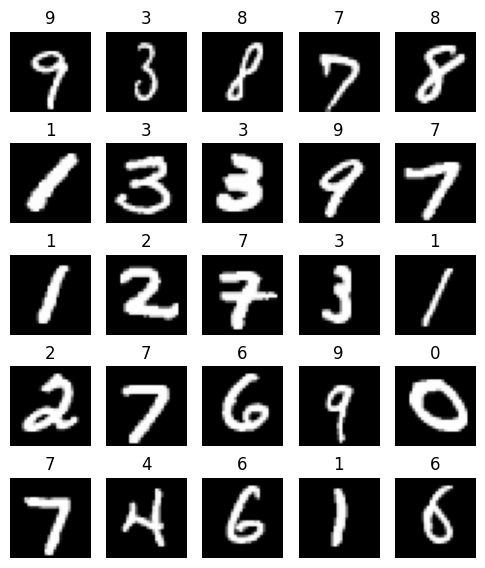

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.297/0.290	Accuracy: 0.922/0.924

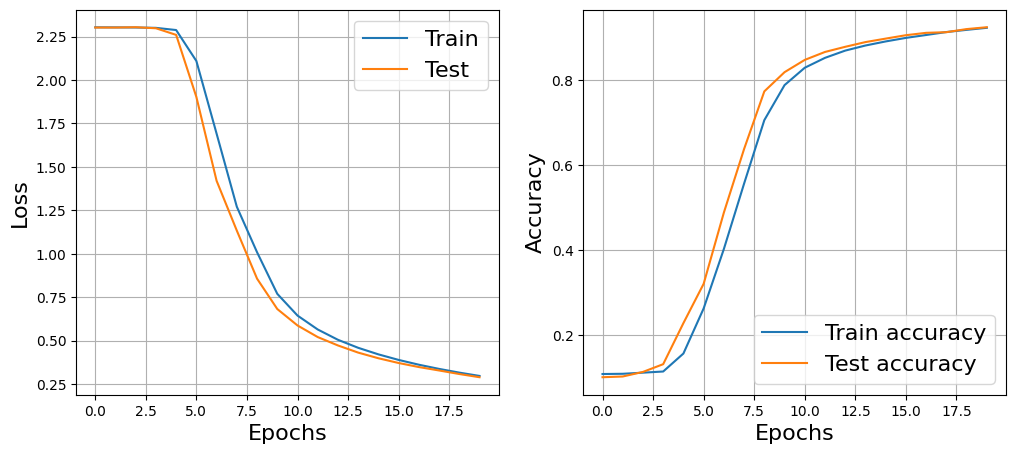

In [7]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [9]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [10]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.036/0.079	Accuracy: 0.990/0.977

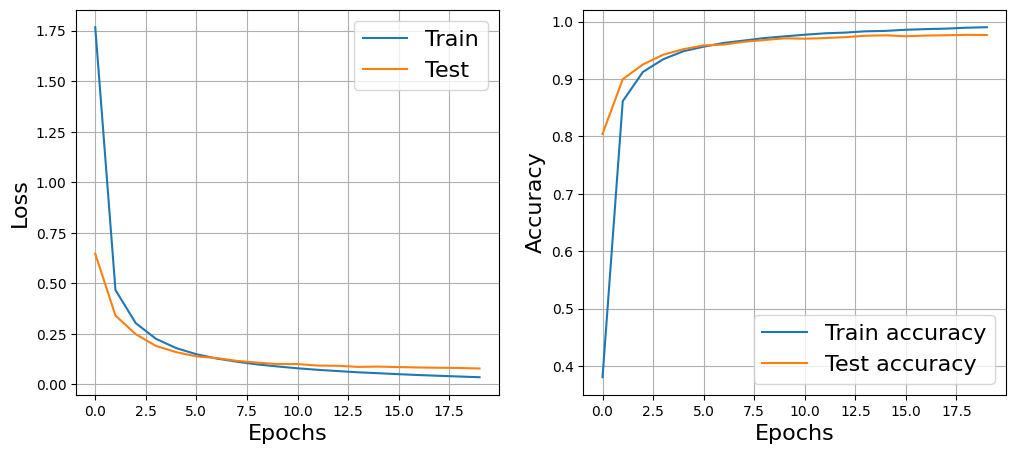

In [11]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.048/0.083	Accuracy: 0.986/0.975

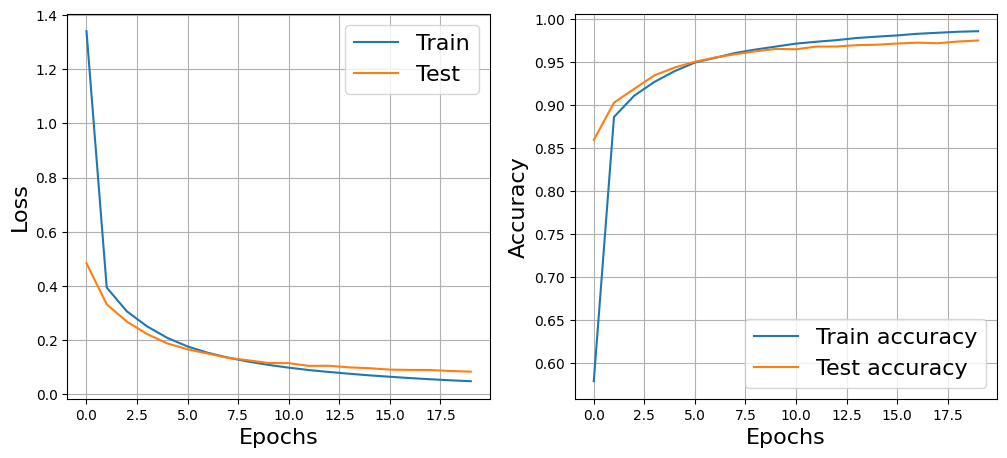

In [12]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

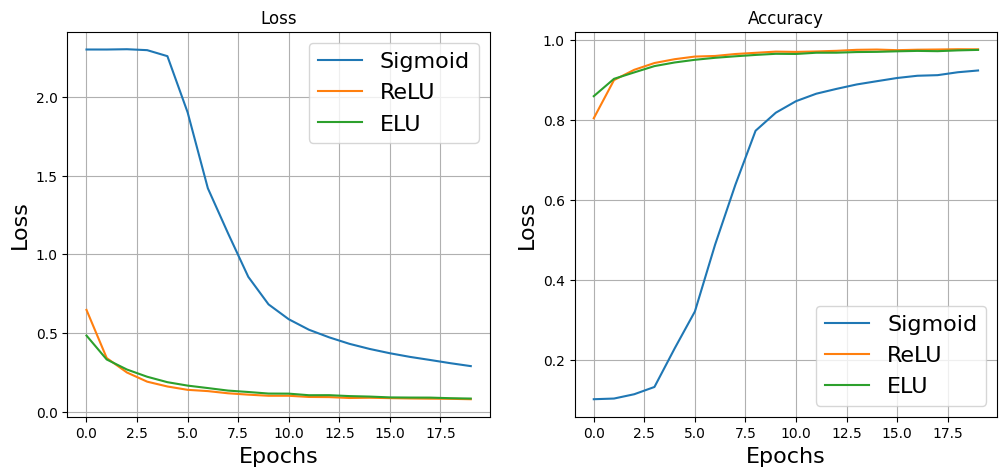

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [14]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        sigm_2x = 1./(1+np.exp(-2*X))
        self.tanh = 2*sigm_2x - 1
        return self.tanh
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = 1 - self.tanh**2
        return dLdy*dydX
    
    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.031/0.078	Accuracy: 0.994/0.976

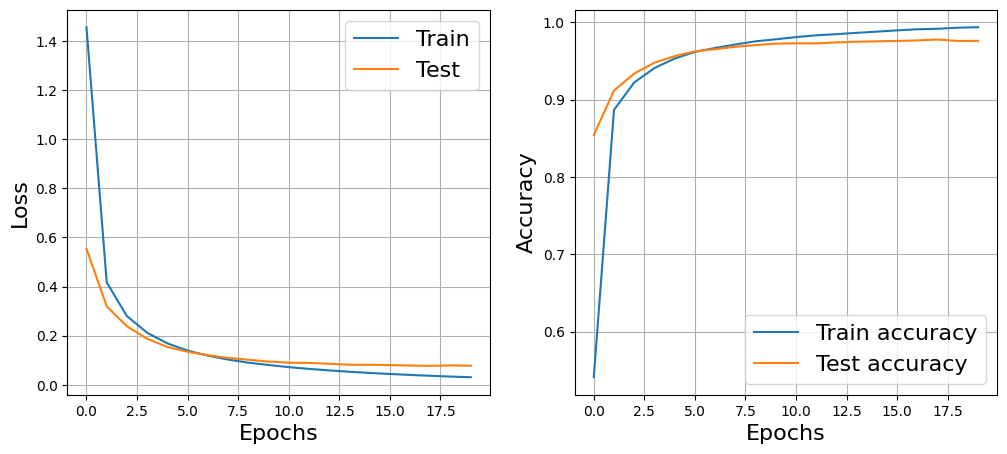

In [15]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

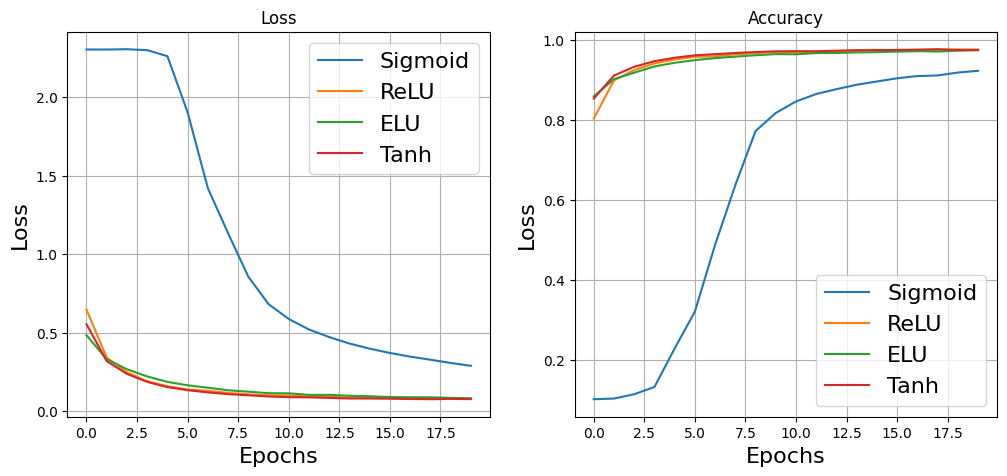

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [17]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

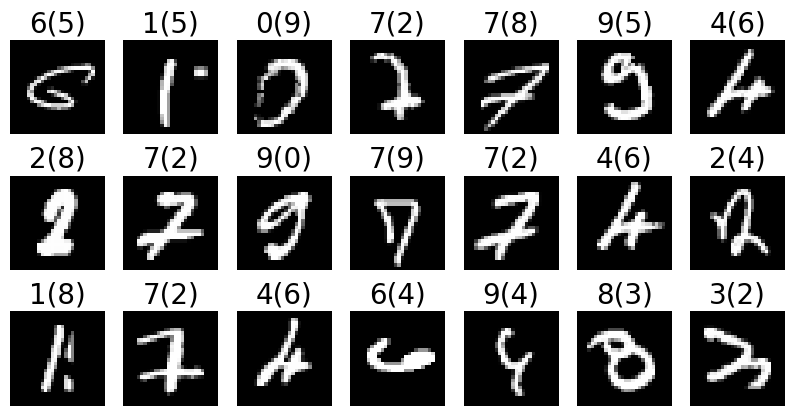

In [18]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [19]:
#!pip install imgaug

In [20]:
import imgaug as ia
from imgaug import augmenters as iaa

In [22]:
augmenter_rot_gaus_shift = iaa.Sequential([
    iaa.Affine(rotate=(-15, 15)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.0025 * 255)),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
])

augmenter_rot_gaus = iaa.Sequential([
    iaa.Affine(rotate=(-15, 15)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.0025 * 255)),
])

augmenter_rot_shift = iaa.Sequential([
    iaa.Affine(rotate=(-15, 15)),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
])

augmenter_gaus_shift = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=(0, 0.0025 * 255)),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
])

augmenter_rot = iaa.Sequential([
    iaa.Affine(rotate=(-15, 15)),
])

augmenter_gaus = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=(0, 0.0025 * 255)),
])

augmenter_shift = iaa.Sequential([
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
])

In [23]:
# data_set to np.image
images_np = [np.array(image) for image, _ in train_dataset]

In [26]:
# for a very long time OR not
images_rot_gaus_shift = augmenter_rot_gaus_shift.augment_images(images_np)
images_rot_gaus = augmenter_rot_gaus.augment_images(images_np)
images_rot_shift = augmenter_rot_shift.augment_images(images_np)
images_gaus_shift = augmenter_gaus_shift.augment_images(images_np)
images_rot = augmenter_rot.augment_images(images_np)
images_gaus = augmenter_gaus.augment_images(images_np)
images_shift = augmenter_shift.augment_images(images_np)


In [27]:
import torch

In [28]:
dataset_rot_gaus_shift = [(torch.from_numpy(image), label.item()) for image, label in zip(images_rot_gaus_shift, train_dataset.targets)]
dataset_rot_gaus = [(torch.from_numpy(image), label.item()) for image, label in zip(images_rot_gaus, train_dataset.targets)]
dataset_rot_shift = [(torch.from_numpy(image), label.item()) for image, label in zip(images_rot_shift, train_dataset.targets)]
dataset_gaus_shift = [(torch.from_numpy(image), label.item()) for image, label in zip(images_gaus_shift, train_dataset.targets)]
dataset_rot = [(torch.from_numpy(image), label.item()) for image, label in zip(images_rot, train_dataset.targets)]
dataset_gaus = [(torch.from_numpy(image), label.item()) for image, label in zip(images_gaus, train_dataset.targets)]
dataset_shift = [(torch.from_numpy(image), label.item()) for image, label in zip(images_shift, train_dataset.targets)]

In [33]:
#checking correct
print(dataset_rot_gaus_shift[100][0].shape, dataset_rot_gaus_shift[100][1])
print(dataset_gaus_shift[100][0].shape, dataset_gaus_shift[100][1])
print(dataset_gaus[100][0].shape, dataset_gaus[100][1])

torch.Size([1, 28, 28]) 5
torch.Size([1, 28, 28]) 5
torch.Size([1, 28, 28]) 5


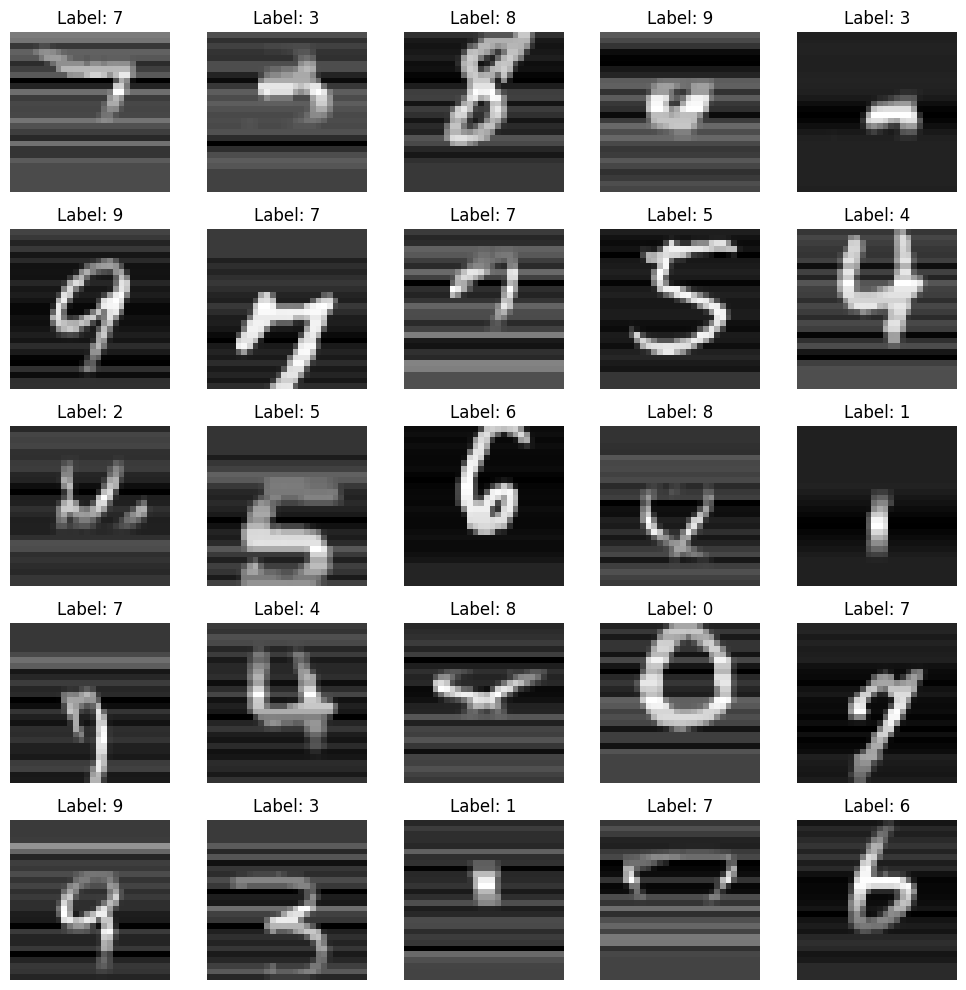

In [35]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset_rot_gaus_shift), size=25, replace=False)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, random_index in enumerate(random_indices):
    image, label = dataset_rot_gaus_shift[random_index]
    ax = axes[i // 5, i % 5]
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [36]:
from torch.utils.data import ConcatDataset

In [37]:
aug_td_rot_gaus_shift = ConcatDataset([train_dataset, dataset_rot_gaus_shift])
aug_td_rot_gaus = ConcatDataset([train_dataset, dataset_rot_gaus])
aug_td_rot_shift = ConcatDataset([train_dataset, dataset_rot_shift])
aug_td_gaus_shift = ConcatDataset([train_dataset, dataset_gaus_shift])
aug_td_rot = ConcatDataset([train_dataset, dataset_rot])
aug_td_gaus = ConcatDataset([train_dataset, dataset_gaus])
aug_td_shift = ConcatDataset([train_dataset, dataset_shift])

In [38]:
#checking correct
print(aug_td_rot_gaus_shift[60005-10][1], aug_td_rot_gaus_shift[60005+10][1])
print(aug_td_gaus_shift[60005-10][1], aug_td_gaus_shift[60005+10][1])

8 7
8 7


In [39]:
aug_dl_rot_gaus_shift = DataLoader(aug_td_rot_gaus_shift, batch_size=32, shuffle=True)
aug_dl_rot_gaus = DataLoader(aug_td_rot_gaus, batch_size=32, shuffle=True)
aug_dl_rot_shift = DataLoader(aug_td_rot_shift, batch_size=32, shuffle=True)
aug_dl_gaus_shift = DataLoader(aug_td_gaus_shift, batch_size=32, shuffle=True)
aug_dl_rot = DataLoader(aug_td_rot, batch_size=32, shuffle=True)
aug_dl_gaus = DataLoader(aug_td_gaus, batch_size=32, shuffle=True)
aug_dl_shift = DataLoader(aug_td_shift, batch_size=32, shuffle=True)

In [41]:
def train_augmented(network, epochs, learning_rate, train_custom_loader, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_custom_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 19... (Train/Test) NLL: 0.167/0.129	Accuracy: 0.945/0.969

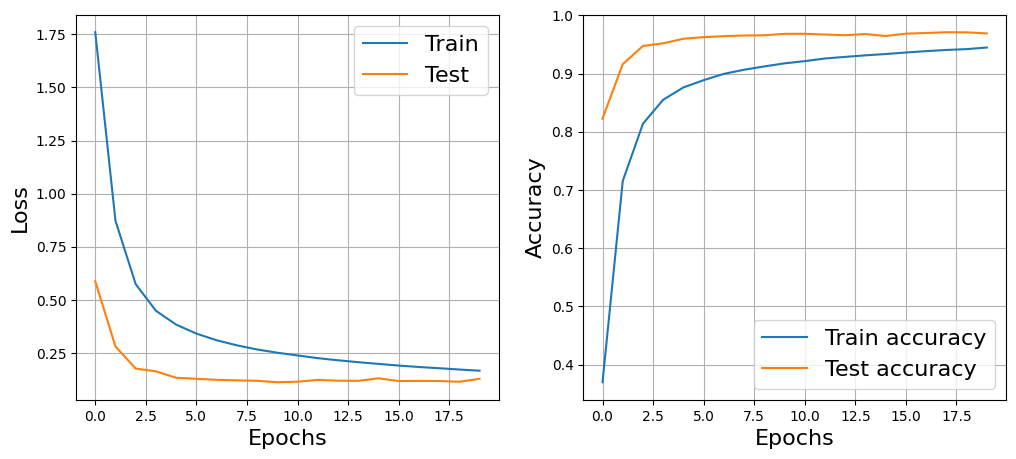

In [42]:
# (1) aug_dl_rot_gaus_shift
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r_rgs, ts_r_rgs, tr_ac_r_rgs, ts_ac_r_rgs = (
    train_augmented(
                    network, 
                    20, 
                    0.01,
                    aug_dl_rot_gaus_shift, 
                    plot=True, 
                    verbose=True
                    ))

Epoch 19... (Train/Test) NLL: 0.080/0.117	Accuracy: 0.973/0.972

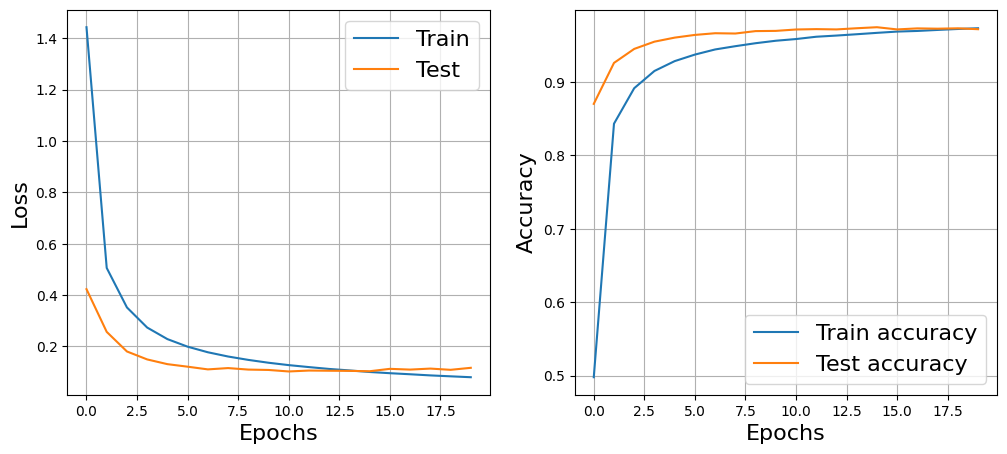

In [43]:
# (2) aug_dl_rot_gaus
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r_rg, ts_r_rg, tr_ac_r_rg, ts_ac_r_rg = (
    train_augmented(
                    network, 
                    20, 
                    0.01,
                    aug_dl_rot_gaus, 
                    plot=True, 
                    verbose=True
                    ))

Epoch 19... (Train/Test) NLL: 0.150/0.123	Accuracy: 0.950/0.971

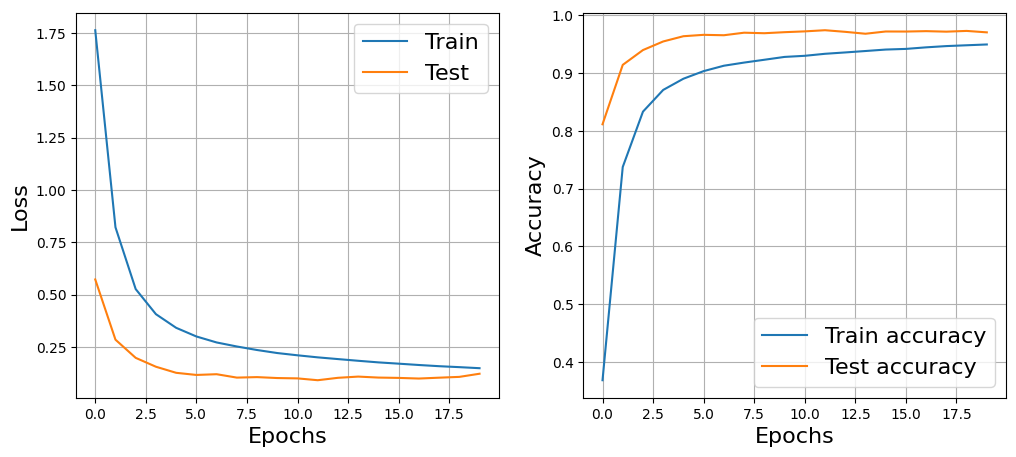

In [44]:
# (3) aug_dl_rot_shift
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r_rs, ts_r_rs, tr_ac_r_rs, ts_ac_r_rs = (
    train_augmented(
                    network, 
                    20, 
                    0.01,
                    aug_dl_rot_shift, 
                    plot=True, 
                    verbose=True
                    ))

Epoch 19... (Train/Test) NLL: 0.042/0.091	Accuracy: 0.988/0.976

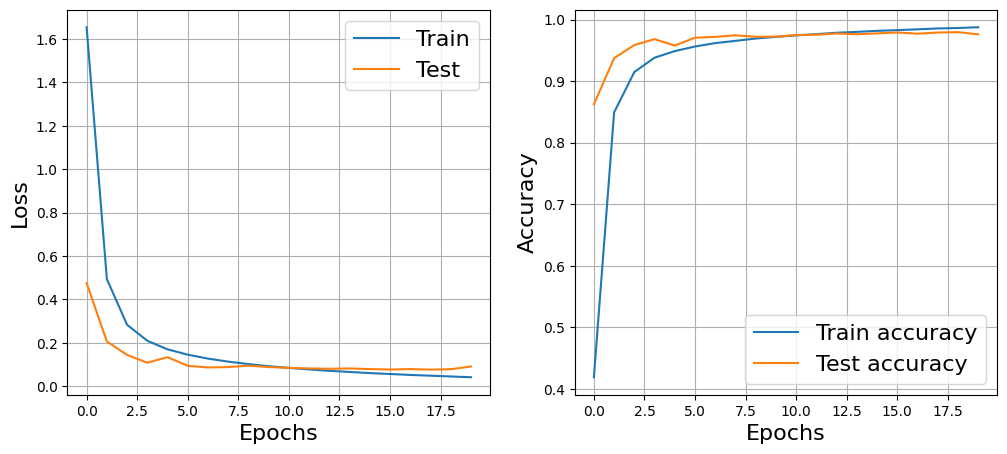

In [45]:
# (4) aug_dl_gaus_shift
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r_gs, ts_r_gs, tr_ac_r_gs, ts_ac_r_gs = (
    train_augmented(
                    network, 
                    20, 
                    0.01,
                    aug_dl_gaus_shift, 
                    plot=True, 
                    verbose=True
                    ))

Epoch 19... (Train/Test) NLL: 0.074/0.096	Accuracy: 0.976/0.975

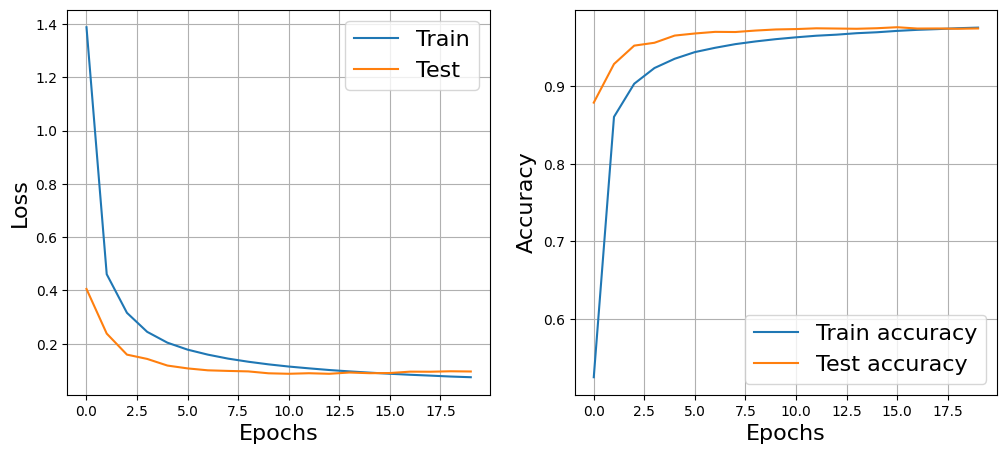

In [46]:
# (5) aug_dl_rot
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r_r, ts_r_r, tr_ac_r_r, ts_ac_r_r = (
    train_augmented(
                    network, 
                    20, 
                    0.01,
                    aug_dl_rot, 
                    plot=True, 
                    verbose=True
                    ))

Epoch 19... (Train/Test) NLL: 0.008/0.094	Accuracy: 0.999/0.976

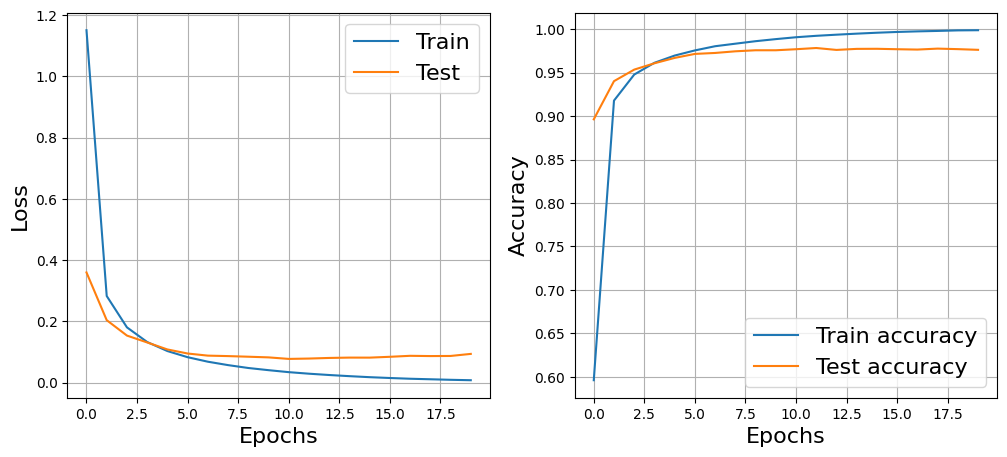

In [47]:
# (6) aug_dl_gaus
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r_g, ts_r_g, tr_ac_r_g, ts_ac_r_g = (
    train_augmented(
                    network, 
                    20, 
                    0.01,
                    aug_dl_gaus, 
                    plot=True, 
                    verbose=True
                    ))

Epoch 19... (Train/Test) NLL: 0.041/0.093	Accuracy: 0.988/0.973

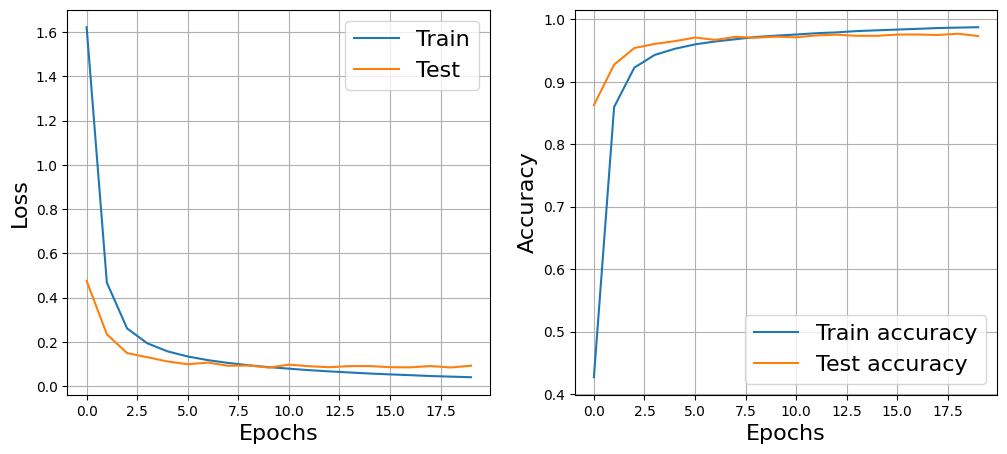

In [48]:
# (7) aug_dl_shift
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r_s, ts_r_s, tr_ac_r_s, ts_ac_r_s = (
    train_augmented(
                    network, 
                    20, 
                    0.01,
                    aug_dl_shift, 
                    plot=True, 
                    verbose=True
                    ))

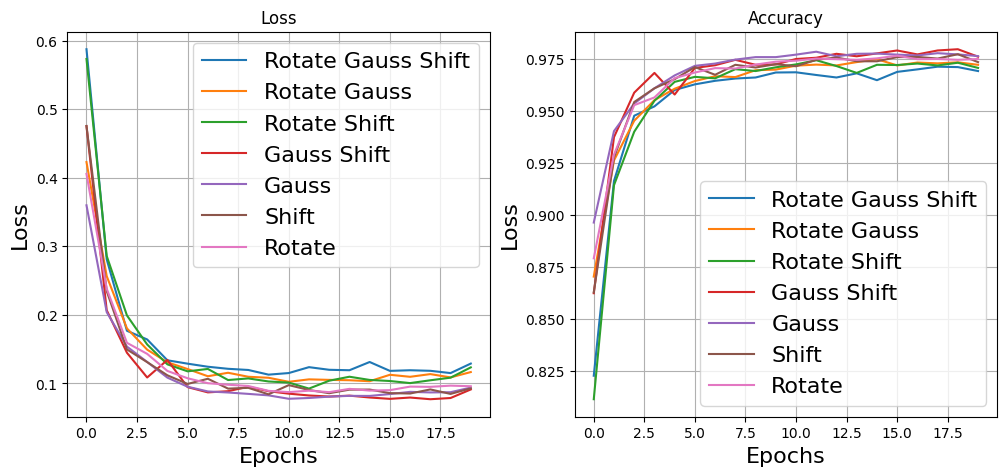

In [49]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_r_rgs, label='Rotate Gauss Shift')
plt.plot(ts_r_rg, label='Rotate Gauss')
plt.plot(ts_r_rs, label='Rotate Shift')
plt.plot(ts_r_gs, label='Gauss Shift')
plt.plot(ts_r_g, label='Gauss')
plt.plot(ts_r_s, label='Shift')
plt.plot(ts_r_r, label='Rotate')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_r_rgs, label='Rotate Gauss Shift')
plt.plot(ts_ac_r_rg, label='Rotate Gauss')
plt.plot(ts_ac_r_rs, label='Rotate Shift')
plt.plot(ts_ac_r_gs, label='Gauss Shift')
plt.plot(ts_ac_r_g, label='Gauss')
plt.plot(ts_ac_r_s, label='Shift')
plt.plot(ts_ac_r_r, label='Rotate')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

1) Наилучшее качество на тестовой выборке по метрике Accuracy и наилучшую скорость сходимости с нелинейным слоем ReLU показала аугментация, в которой применялся гауссовский шум и сдвиг. Также неплохое качество показала аугментация, в которой применялся только гауссовский шум. Аугментация со всеми тремя элементами показала самый плохой результат.
2) ReLU, ELU и Tanh показывают наилучшее качество и лучшую скорость сходимости в отличии от Sigmoidы.
   Однако, обычно ReLU и ELU имееют более высокую скорость сходимости в отличии от Sigmoid и Tanh благодаря отсутствию проблемы затухания градиентов и из-за потребления намного меньше вычислительных ресурсов при расчёте градиентов и значений самой функции.